## PART I 

In [131]:
#importing all libraries

import pandas as pd
from nltk.corpus import stopwords
import re
import nltk
from collections import Counter
import math
from time import time
from collections import defaultdict  # For word frequency
from sklearn.feature_extraction.text import TfidfVectorizer

import spacy 
import logging 
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

## 1.1 DATA PREPARATION

In [132]:
df= pd.read_csv("simpsons_dataset.csv")

df.shape

(158314, 2)

## 1.2 WORD REPRESENTATION

### 1.2.1 Unique Names.. Necessary preprocessing.. 

In [133]:
# drop rows with NaN
df = df.dropna(subset=['raw_character_text', 'spoken_words'])

#all lowercase
df['spoken_words'] = df['spoken_words'].str.lower()

#remove punctuation using regex 
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text) #any char that is not a word char(\w) and not whitespace (\s)

df['spoken_words'] = df['spoken_words'].apply(remove_punctuation)

#remove stopwords 
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split() # split the text into individual words
    filtered_words = []

    # loop through each word in the list of words
    for word in words:

        if word not in stop_words:
            filtered_words.append(word)

    cleaned_text = ' '.join(filtered_words)
    return cleaned_text


df['spoken_words'] = df['spoken_words'].apply(remove_stopwords)
df.shape

(131853, 2)

In [134]:
# unique character names
unique_characters = df['raw_character_text'].unique()

#create documents
documents = df.groupby('raw_character_text')['spoken_words'].apply(lambda x: ' '.join(x)).reset_index()
documents.shape
# FOR MYSELF 
#Save the gathered dialogues to an Excel file
# output_path = "../simpsons_character_dialogues.xlsx"
# documents.to_excel(output_path, index=False)

(6272, 2)

In [135]:

documents.head(5)


,raw_character_text,spoken_words
0,'30s Reporter,kinda show got us mr burns sensational
1,'70s Announcer,paul lyndehelen reddyhudson brothers easter sp...
2,1-Year-Old Bart,daddy nice daddy moustache daddy good daddy no...
3,1-Year-Old Homer,mommy
4,1-Year-Old Nelson,haw haw


### 1.2.2 Find the 2 most frequent words ( with more than 3 letters) 
by Lisa Simpson, Bart Simpson & Homer Simpson

In [241]:
chars = ['Lisa Simpson', 'Bart Simpson', 'Homer Simpson']

def get_most_common_words(character):

    filtered_docs = documents[documents['raw_character_text'] == character]

    combined_dialogue = ' '.join(filtered_docs['spoken_words'])
    
    # Tokenization
    words = combined_dialogue.split()
    filtered_words = [word for word in words if len(word) > 3] 
    
    # count frequency of each word
    word_counts = Counter(filtered_words)
    
    #  2 most common words
    return word_counts.most_common(2)

In [242]:
for character in chars:
    most_common_words = get_most_common_words(character)
    print(f"2 most frequent spoken words by {character}:")
    for word, count in most_common_words:
        print(f"{word}")
    print()  

2 most frequent spoken words by Lisa Simpson:
bart
dont

2 most frequent spoken words by Bart Simpson:
dont
like

2 most frequent spoken words by Homer Simpson:
marge
dont



## TF IDF Function Calculation

In [246]:
def get_most_common_words(character):
    filtered_docs = documents[documents['raw_character_text'] == character]
    combined_dialogue = ' '.join(filtered_docs['spoken_words'])
    
    # Tokenization
    words = combined_dialogue.split()
    filtered_words = [word for word in words if len(word) > 3] 
    
    # Count frequency of each word
    word_counts = Counter(filtered_words)
    
    # 2 most common words
    return word_counts.most_common(2), combined_dialogue

In [247]:
tf_idf_results = {}

# corpus
N = len(documents)

for character in chars:
    most_common_words, combined_dialogue = get_most_common_words(character)
    
    #  total words in document
    total_words = len(combined_dialogue.split())
    
    character_tf_idf = {}
    
    for word, count in most_common_words:
        # Calculate TF
        tf = count / total_words
        
        # Calculate IDF
        n = sum(1 for doc in documents['spoken_words'] if word in doc) 
        idf = log(N / (n))
        
        # Calculate TF-IDF
        tf_idf = tf * idf
        
        character_tf_idf[word] = {
            'TF': tf,
            'IDF': idf,
            'TF-IDF': tf_idf
        }
    
    # results per char
    tf_idf_results[character] = character_tf_idf

In [248]:

# Print the results
for character, results in tf_idf_results.items():
    print(f"\nTF-IDF Results for {character}:")
    for word, metrics in results.items():
        print(f"{word} - TF: {metrics['TF']:.4f}, IDF: {metrics['IDF']:.4f}, TF-IDF: {metrics['TF-IDF']:.4f}")


TF-IDF Results for Lisa Simpson:
bart - TF: 0.0132, IDF: 2.9913, TF-IDF: 0.0395
dont - TF: 0.0108, IDF: 1.8655, TF-IDF: 0.0202

TF-IDF Results for Bart Simpson:
dont - TF: 0.0102, IDF: 1.8655, TF-IDF: 0.0189
like - TF: 0.0079, IDF: 1.8134, TF-IDF: 0.0144

TF-IDF Results for Homer Simpson:
marge - TF: 0.0118, IDF: 3.2971, TF-IDF: 0.0390
dont - TF: 0.0101, IDF: 1.8655, TF-IDF: 0.0189


In [ ]:
#tried this function too , i dont know if this was correct 

In [138]:

# # preprocessing
# def preprocess(doc):
#     words = doc.split()  # Tokenize
#     return [word for word in words if len(word) > 3]

# #  tokenized documents for each character
# docs = filtered_docs['spoken_words'].tolist()
# tokenized_docs = [preprocess(doc) for doc in docs]

# # calculate tf 
# def compute_tf(doc):
#     total_words = len(doc)
#     word_counts = Counter(doc)
#     tf = {word: count / total_words for word, count in word_counts.items()}
#     return tf

# # tf for each doc
# tf_docs = [compute_tf(doc) for doc in tokenized_docs]

# # calculate df
# def compute_df(docs):
#     df = Counter()
#     for doc in docs:
#         unique_words = set(doc)
#         for word in unique_words:
#             df[word] += 1
#     return df

# # df in all documents
# df_counts = compute_df(tokenized_docs)

# # idf
# def compute_idf(docs, df):
#     total_docs = len(docs)
#     idf = {word: math.log(total_docs / df[word]) for word in df}
#     return idf

# idf_values = compute_idf(tokenized_docs, df_counts)

# # tf idf 
# def compute_tfidf(tf, idf):
#     tfidf = {word: tf[word] * idf[word] for word in tf}
#     return tfidf

# # tf idf for each document
# tfidf_docs = [compute_tfidf(tf, idf_values) for tf in tf_docs]

# # print results
# for i, tfidf in enumerate(tfidf_docs):
#     character = chars[i]
#     print(f"TF-IDF for {character}:")
#     sorted_tfidf = sorted(tfidf.items(), key=lambda x: -x[1])[:10]  # top 10 words by TF-IDF score

#     for word, value in sorted_tfidf:
#         print(f"{word}: {value:.5f}")


TF-IDF for Lisa Simpson:
carumba: 0.00061
ottoman: 0.00025
crap: 0.00022
gettin: 0.00017
bent: 0.00016
detention: 0.00016
loser: 0.00015
crappy: 0.00014
divorced: 0.00014
trained: 0.00014
TF-IDF for Bart Simpson:
sweetie: 0.00034
barney: 0.00026
marges: 0.00023
crap: 0.00017
sweetheart: 0.00017
voop: 0.00016
yello: 0.00016
blah: 0.00014
lottery: 0.00013
dada: 0.00013
TF-IDF for Homer Simpson:
bergstrom: 0.00039
juliet: 0.00027
buddhist: 0.00024
yayyy: 0.00022
stacy: 0.00019
seeds: 0.00017
nancy: 0.00015
bonney: 0.00015
loora: 0.00015
raymondo: 0.00015


### 1.2.3 Using gensim library for implementation of word2vec,

In [139]:
nlp = spacy.load('en_core_web_sm',disable=['ner', 'parser']) # disabling for speed

def cleaning(doc):
    txt = [token.lemma_ for token in doc if not token.is_stop]
    if len(txt) > 2:
        return ' '.join(txt)
    
brief_cleaning = df['spoken_words'].apply(remove_punctuation)  
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]

print('time to clean: {} mins'.format(round((time() - t) / 60, 2)))

df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

time to clean: 1.44 mins


(89587, 1)

 **Phrases** class looks for common pairs of words (like "New York" or "high school") in a bunch of sentences.
 After training the Phrases model, you can use the Phraser to transform new sentences. The Phraser will know which phrases to look for based on the vocabulary created during the training phase.


In [140]:
from gensim.models.phrases import Phrases, Phraser
sent = [row.split() for row in df_clean['clean']] # we split words in tokens. 

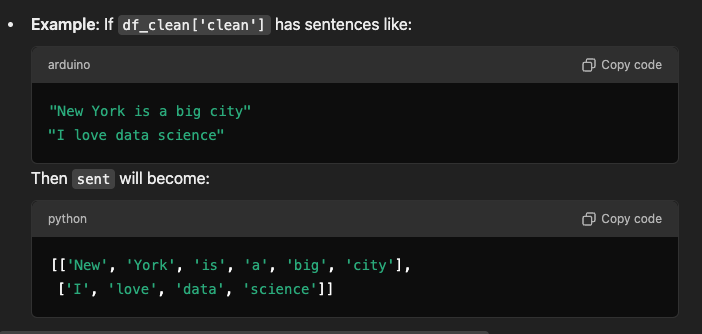

In [141]:
# create a Phrases model using  list of tokenized sentences "sent"
phrases = Phrases(sent, min_count=30, progress_per=10000) 

# bigrams convey distinct meeaning. 
bigram = Phraser(phrases) # Eg: "New" and "York" are 2 different words. but "New York" is 1 single entity
sentences = bigram[sent] #this is our data 

INFO - 17:00:20: collecting all words and their counts
INFO - 17:00:20: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 17:00:20: PROGRESS: at sentence #10000, processed 65461 words and 52705 word types
INFO - 17:00:20: PROGRESS: at sentence #20000, processed 135794 words and 100169 word types
INFO - 17:00:20: PROGRESS: at sentence #30000, processed 200232 words and 138568 word types
INFO - 17:00:20: PROGRESS: at sentence #40000, processed 259451 words and 172991 word types
INFO - 17:00:20: PROGRESS: at sentence #50000, processed 321222 words and 207584 word types
INFO - 17:00:20: PROGRESS: at sentence #60000, processed 385294 words and 242681 word types
INFO - 17:00:20: PROGRESS: at sentence #70000, processed 449879 words and 277318 word types
INFO - 17:00:21: PROGRESS: at sentence #80000, processed 513555 words and 311122 word types
INFO - 17:00:21: collected 341679 token types (unigram + bigrams) from a corpus of 577228 words and 89587 sentences
INFO - 17:00:21: 

In [142]:
#calculating freq
word_freq = defaultdict(int)  # store word frequencies
for s in sentences:         
    for i in s:            
        word_freq[i] += 1    
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['not', 's', 'm', 'oh', 'like', 'know', 'hey', 'think', 'right', 'look']

In [168]:
from gensim.models import Word2Vec
import multiprocessing

# Parameters for different Word2Vec models
params = [(5, 100, 5), (5, 100, 15), (5, 300, 5), (5, 300, 15),
          (10, 100, 5), (10, 100, 15), (10, 300, 5), (10, 300, 15)]

models = {}

# Loop over the parameters to create and train models
for i, (window, vector_size, negative) in enumerate(params):
    try:
        # Create the Word2Vec model
        model = Word2Vec(min_count=20,
                         window=window,
                         vector_size=vector_size,
                         sample=6e-5,
                         alpha=0.03,
                         min_alpha=0.0007,
                         negative=negative,
                         workers=multiprocessing.cpu_count()-1)

        # Build vocabulary
        model.build_vocab(sentences, progress_per=10000)

        # Train the model
        model.train(sentences, total_examples=model.corpus_count, epochs=15, report_delay=.1)

        # Store the model in the dictionary
        models[f'w2v_model{i+1}'] = model
        print(f"Successfully created and trained w2v_model{i+1}")
        
    except Exception as e:
        print(f"Error creating model w2v_model{i+1}: {e}")

INFO - 17:07:18: Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=100, alpha=0.03>', 'datetime': '2024-10-14T17:07:18.216338', 'gensim': '4.3.3', 'python': '3.9.17 (main, Jul  5 2023, 16:17:03) \n[Clang 14.0.6 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
INFO - 17:07:18: collecting all words and their counts
INFO - 17:07:18: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 17:07:18: PROGRESS: at sentence #10000, processed 63328 words, keeping 9971 word types
INFO - 17:07:18: PROGRESS: at sentence #20000, processed 131511 words, keeping 15588 word types
INFO - 17:07:18: PROGRESS: at sentence #30000, processed 194123 words, keeping 19186 word types
INFO - 17:07:18: PROGRESS: at sentence #40000, processed 251694 words, keeping 22520 word types
INFO - 17:07:18: PROGRESS: at sentence #50000, processed 311594 words, keeping 25504 word types
INFO - 17:07:18: PROGRESS: at sentence #60000, processed 373819 words, keeping 28450 wo

INFO - 17:07:45: EPOCH 28: training on 560399 raw words (201963 effective words) took 0.8s, 258445 effective words/s
INFO - 17:07:46: EPOCH 29 - PROGRESS: at 48.19% examples, 96547 words/s, in_qsize 13, out_qsize 0
INFO - 17:07:46: EPOCH 29 - PROGRESS: at 62.59% examples, 113002 words/s, in_qsize 14, out_qsize 0
INFO - 17:07:46: EPOCH 29: training on 560399 raw words (201645 effective words) took 1.2s, 172512 effective words/s
INFO - 17:07:46: Word2Vec lifecycle event {'msg': 'training on 16811970 raw words (6050579 effective words) took 27.4s, 220908 effective words/s', 'datetime': '2024-10-14T17:07:46.407411', 'gensim': '4.3.3', 'python': '3.9.17 (main, Jul  5 2023, 16:17:03) \n[Clang 14.0.6 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'train'}
INFO - 17:07:46: Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=100, alpha=0.03>', 'datetime': '2024-10-14T17:07:46.408275', 'gensim': '4.3.3', 'python': '3.9.17 (main, Jul  5 2023, 16:17:03) \n[Clang 14.0.6 ]'

Successfully created and trained w2v_model1


INFO - 17:07:46: PROGRESS: at sentence #30000, processed 194123 words, keeping 19186 word types
INFO - 17:07:46: PROGRESS: at sentence #40000, processed 251694 words, keeping 22520 word types
INFO - 17:07:46: PROGRESS: at sentence #50000, processed 311594 words, keeping 25504 word types
INFO - 17:07:46: PROGRESS: at sentence #60000, processed 373819 words, keeping 28450 word types
INFO - 17:07:46: PROGRESS: at sentence #70000, processed 436631 words, keeping 31226 word types
INFO - 17:07:47: PROGRESS: at sentence #80000, processed 498648 words, keeping 33940 word types
INFO - 17:07:47: collected 35942 word types from a corpus of 560399 raw words and 89587 sentences
INFO - 17:07:47: Creating a fresh vocabulary
INFO - 17:07:47: Word2Vec lifecycle event {'msg': 'effective_min_count=20 retains 3242 unique words (9.02% of original 35942, drops 32700)', 'datetime': '2024-10-14T17:07:47.138657', 'gensim': '4.3.3', 'python': '3.9.17 (main, Jul  5 2023, 16:17:03) \n[Clang 14.0.6 ]', 'platform':

INFO - 17:08:15: collecting all words and their counts
INFO - 17:08:15: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 17:08:15: PROGRESS: at sentence #10000, processed 63328 words, keeping 9971 word types


Successfully created and trained w2v_model2


INFO - 17:08:15: PROGRESS: at sentence #20000, processed 131511 words, keeping 15588 word types
INFO - 17:08:15: PROGRESS: at sentence #30000, processed 194123 words, keeping 19186 word types
INFO - 17:08:15: PROGRESS: at sentence #40000, processed 251694 words, keeping 22520 word types
INFO - 17:08:16: PROGRESS: at sentence #50000, processed 311594 words, keeping 25504 word types
INFO - 17:08:16: PROGRESS: at sentence #60000, processed 373819 words, keeping 28450 word types
INFO - 17:08:16: PROGRESS: at sentence #70000, processed 436631 words, keeping 31226 word types
INFO - 17:08:16: PROGRESS: at sentence #80000, processed 498648 words, keeping 33940 word types
INFO - 17:08:16: collected 35942 word types from a corpus of 560399 raw words and 89587 sentences
INFO - 17:08:16: Creating a fresh vocabulary
INFO - 17:08:16: Word2Vec lifecycle event {'msg': 'effective_min_count=20 retains 3242 unique words (9.02% of original 35942, drops 32700)', 'datetime': '2024-10-14T17:08:16.362862', 'g

INFO - 17:08:44: collecting all words and their counts
INFO - 17:08:44: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 17:08:44: PROGRESS: at sentence #10000, processed 63328 words, keeping 9971 word types
INFO - 17:08:44: PROGRESS: at sentence #20000, processed 131511 words, keeping 15588 word types


Successfully created and trained w2v_model3


INFO - 17:08:44: PROGRESS: at sentence #30000, processed 194123 words, keeping 19186 word types
INFO - 17:08:44: PROGRESS: at sentence #40000, processed 251694 words, keeping 22520 word types
INFO - 17:08:44: PROGRESS: at sentence #50000, processed 311594 words, keeping 25504 word types
INFO - 17:08:44: PROGRESS: at sentence #60000, processed 373819 words, keeping 28450 word types
INFO - 17:08:44: PROGRESS: at sentence #70000, processed 436631 words, keeping 31226 word types
INFO - 17:08:44: PROGRESS: at sentence #80000, processed 498648 words, keeping 33940 word types
INFO - 17:08:44: collected 35942 word types from a corpus of 560399 raw words and 89587 sentences
INFO - 17:08:44: Creating a fresh vocabulary
INFO - 17:08:44: Word2Vec lifecycle event {'msg': 'effective_min_count=20 retains 3242 unique words (9.02% of original 35942, drops 32700)', 'datetime': '2024-10-14T17:08:44.863442', 'gensim': '4.3.3', 'python': '3.9.17 (main, Jul  5 2023, 16:17:03) \n[Clang 14.0.6 ]', 'platform':

INFO - 17:09:13: EPOCH 27: training on 560399 raw words (201987 effective words) took 1.2s, 163732 effective words/s
INFO - 17:09:14: EPOCH 28: training on 560399 raw words (201643 effective words) took 0.9s, 229504 effective words/s
INFO - 17:09:14: EPOCH 29: training on 560399 raw words (201517 effective words) took 0.9s, 225238 effective words/s
INFO - 17:09:14: Word2Vec lifecycle event {'msg': 'training on 16811970 raw words (6049600 effective words) took 30.0s, 201712 effective words/s', 'datetime': '2024-10-14T17:09:14.903532', 'gensim': '4.3.3', 'python': '3.9.17 (main, Jul  5 2023, 16:17:03) \n[Clang 14.0.6 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'train'}
INFO - 17:09:14: Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=100, alpha=0.03>', 'datetime': '2024-10-14T17:09:14.904482', 'gensim': '4.3.3', 'python': '3.9.17 (main, Jul  5 2023, 16:17:03) \n[Clang 14.0.6 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
INFO - 17:09:

Successfully created and trained w2v_model4


INFO - 17:09:15: PROGRESS: at sentence #30000, processed 194123 words, keeping 19186 word types
INFO - 17:09:15: PROGRESS: at sentence #40000, processed 251694 words, keeping 22520 word types
INFO - 17:09:15: PROGRESS: at sentence #50000, processed 311594 words, keeping 25504 word types
INFO - 17:09:15: PROGRESS: at sentence #60000, processed 373819 words, keeping 28450 word types
INFO - 17:09:15: PROGRESS: at sentence #70000, processed 436631 words, keeping 31226 word types
INFO - 17:09:15: PROGRESS: at sentence #80000, processed 498648 words, keeping 33940 word types
INFO - 17:09:15: collected 35942 word types from a corpus of 560399 raw words and 89587 sentences
INFO - 17:09:15: Creating a fresh vocabulary
INFO - 17:09:15: Word2Vec lifecycle event {'msg': 'effective_min_count=20 retains 3242 unique words (9.02% of original 35942, drops 32700)', 'datetime': '2024-10-14T17:09:15.627868', 'gensim': '4.3.3', 'python': '3.9.17 (main, Jul  5 2023, 16:17:03) \n[Clang 14.0.6 ]', 'platform':

INFO - 17:09:43: Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=100, alpha=0.03>', 'datetime': '2024-10-14T17:09:43.498089', 'gensim': '4.3.3', 'python': '3.9.17 (main, Jul  5 2023, 16:17:03) \n[Clang 14.0.6 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
INFO - 17:09:43: collecting all words and their counts
INFO - 17:09:43: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 17:09:43: PROGRESS: at sentence #10000, processed 63328 words, keeping 9971 word types
INFO - 17:09:43: PROGRESS: at sentence #20000, processed 131511 words, keeping 15588 word types


Successfully created and trained w2v_model5


INFO - 17:09:43: PROGRESS: at sentence #30000, processed 194123 words, keeping 19186 word types
INFO - 17:09:43: PROGRESS: at sentence #40000, processed 251694 words, keeping 22520 word types
INFO - 17:09:43: PROGRESS: at sentence #50000, processed 311594 words, keeping 25504 word types
INFO - 17:09:43: PROGRESS: at sentence #60000, processed 373819 words, keeping 28450 word types
INFO - 17:09:44: PROGRESS: at sentence #70000, processed 436631 words, keeping 31226 word types
INFO - 17:09:44: PROGRESS: at sentence #80000, processed 498648 words, keeping 33940 word types
INFO - 17:09:44: collected 35942 word types from a corpus of 560399 raw words and 89587 sentences
INFO - 17:09:44: Creating a fresh vocabulary
INFO - 17:09:44: Word2Vec lifecycle event {'msg': 'effective_min_count=20 retains 3242 unique words (9.02% of original 35942, drops 32700)', 'datetime': '2024-10-14T17:09:44.220899', 'gensim': '4.3.3', 'python': '3.9.17 (main, Jul  5 2023, 16:17:03) \n[Clang 14.0.6 ]', 'platform':

INFO - 17:10:12: collecting all words and their counts
INFO - 17:10:12: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 17:10:12: PROGRESS: at sentence #10000, processed 63328 words, keeping 9971 word types
INFO - 17:10:12: PROGRESS: at sentence #20000, processed 131511 words, keeping 15588 word types


Successfully created and trained w2v_model6


INFO - 17:10:12: PROGRESS: at sentence #30000, processed 194123 words, keeping 19186 word types
INFO - 17:10:12: PROGRESS: at sentence #40000, processed 251694 words, keeping 22520 word types
INFO - 17:10:12: PROGRESS: at sentence #50000, processed 311594 words, keeping 25504 word types
INFO - 17:10:12: PROGRESS: at sentence #60000, processed 373819 words, keeping 28450 word types
INFO - 17:10:13: PROGRESS: at sentence #70000, processed 436631 words, keeping 31226 word types
INFO - 17:10:13: PROGRESS: at sentence #80000, processed 498648 words, keeping 33940 word types
INFO - 17:10:13: collected 35942 word types from a corpus of 560399 raw words and 89587 sentences
INFO - 17:10:13: Creating a fresh vocabulary
INFO - 17:10:13: Word2Vec lifecycle event {'msg': 'effective_min_count=20 retains 3242 unique words (9.02% of original 35942, drops 32700)', 'datetime': '2024-10-14T17:10:13.183460', 'gensim': '4.3.3', 'python': '3.9.17 (main, Jul  5 2023, 16:17:03) \n[Clang 14.0.6 ]', 'platform':

INFO - 17:10:41: Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.03>', 'datetime': '2024-10-14T17:10:41.015643', 'gensim': '4.3.3', 'python': '3.9.17 (main, Jul  5 2023, 16:17:03) \n[Clang 14.0.6 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
INFO - 17:10:41: collecting all words and their counts
INFO - 17:10:41: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 17:10:41: PROGRESS: at sentence #10000, processed 63328 words, keeping 9971 word types
INFO - 17:10:41: PROGRESS: at sentence #20000, processed 131511 words, keeping 15588 word types


Successfully created and trained w2v_model7


INFO - 17:10:41: PROGRESS: at sentence #30000, processed 194123 words, keeping 19186 word types
INFO - 17:10:41: PROGRESS: at sentence #40000, processed 251694 words, keeping 22520 word types
INFO - 17:10:41: PROGRESS: at sentence #50000, processed 311594 words, keeping 25504 word types
INFO - 17:10:41: PROGRESS: at sentence #60000, processed 373819 words, keeping 28450 word types
INFO - 17:10:41: PROGRESS: at sentence #70000, processed 436631 words, keeping 31226 word types
INFO - 17:10:41: PROGRESS: at sentence #80000, processed 498648 words, keeping 33940 word types
INFO - 17:10:41: collected 35942 word types from a corpus of 560399 raw words and 89587 sentences
INFO - 17:10:41: Creating a fresh vocabulary
INFO - 17:10:41: Word2Vec lifecycle event {'msg': 'effective_min_count=20 retains 3242 unique words (9.02% of original 35942, drops 32700)', 'datetime': '2024-10-14T17:10:41.737348', 'gensim': '4.3.3', 'python': '3.9.17 (main, Jul  5 2023, 16:17:03) \n[Clang 14.0.6 ]', 'platform':

INFO - 17:11:12: EPOCH 29 - PROGRESS: at 68.03% examples, 120515 words/s, in_qsize 8, out_qsize 1
INFO - 17:11:12: EPOCH 29 - PROGRESS: at 98.30% examples, 159919 words/s, in_qsize 1, out_qsize 1
INFO - 17:11:12: EPOCH 29: training on 560399 raw words (202178 effective words) took 1.2s, 162624 effective words/s
INFO - 17:11:12: Word2Vec lifecycle event {'msg': 'training on 16811970 raw words (6051327 effective words) took 30.4s, 198876 effective words/s', 'datetime': '2024-10-14T17:11:12.215991', 'gensim': '4.3.3', 'python': '3.9.17 (main, Jul  5 2023, 16:17:03) \n[Clang 14.0.6 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'train'}


Successfully created and trained w2v_model8
Models created: dict_keys(['w2v_model1', 'w2v_model2', 'w2v_model3', 'w2v_model4', 'w2v_model5', 'w2v_model6', 'w2v_model7', 'w2v_model8'])
Successfully accessed model3.


### 1.2.4 Comparing the models in terms of following : 


## Homer , Simpson, Marge, Bart
<img src=https://upload.wikimedia.org/wikipedia/en/0/02/Homer_Simpson_2006.png width="100">


<img src=https://m.media-amazon.com/images/M/MV5BNTU2OWE0YWYtMjRlMS00NTUwLWJmZWUtODFhNzJiMGJlMzI3XkEyXkFqcGc@._V1_FMjpg_UX1000_.jpg
     width="100">  <img src=https://facts.net/wp-content/uploads/2023/09/10-facts-about-marge-simpson-the-simpsons-1693811923.jpg width="150">
     
 <img src=https://facts.net/wp-content/uploads/2023/08/19-facts-about-bart-simpson-the-simpsons-1693479522.jpg width="100">

In [206]:
def get_similar_words(models, word):
    results = {
        'Model': [],
        'Similar Words': []
    }

    # Iterate over the models and retrieve the most similar words
    for model_name, model in models.items():
        similar_words = model.wv.most_similar(positive=[word])
        results['Model'].append(model_name)
        results['Similar Words'].append([word for word, _ in similar_words])
        
    return pd.DataFrame(results)

words_to_check = ["homer", "simpson", "marge", "bart"]

for i in words_to_check:
    similarity_df = get_similar_words(models, i)
    print(f"Similar words for '{i}':")
    print(similarity_df.to_string(index=False))
    print("\n" + "="*100 + "\n")


Similar words for 'homer':
     Model                                                                           Similar Words
w2v_model1 [marge, bartender, drunk, snuggle, abe, wife, crummy, sweetheart, shoulda, good_friend]
w2v_model2  [marge, good_friend, shoulda, heck, brunch, snuggle, bartender, convince, workin, not]
w2v_model3           [marge, bartender, rude, comfort, friendship, wife, drunk, abe, moe, shoulda]
w2v_model4   [marge, rude, crummy, gee, sweetheart, confidence, rapture, comfort, awfully, creepy]
w2v_model5            [bartender, marge, snuggle, moe, brunch, rude, drunk, convince, apu, crummy]
w2v_model6               [marge, gee, snuggle, sweetheart, ashamed, crummy, meow, max, pfft, rude]
w2v_model7      [crummy, rude, married, marge, drunk, wife, snuggle, bartender, convince, shoulda]
w2v_model8      [marge, drunk, creepy, bartender, hammock, sweetheart, snuggle, saw, asleep, brad]


Similar words for 'simpson':
     Model                                         

## (Maggie, Baby) & ( Bart, Nelson)
<img src=https://upload.wikimedia.org/wikipedia/en/9/9d/Maggie_Simpson.png width="100">

<img src=https://upload.wikimedia.org/wikipedia/en/thumb/c/c6/Nelson_Muntz.PNG/160px-Nelson_Muntz.PNG width="100">

In [209]:
def get_similarity_across_models(models, word1, word2):
    res = []

    #  similarity for each model
    for model_name, model in models.items():
        similarity = model.wv.similarity(word1, word2)
        res.append((model_name, similarity))

    return pd.DataFrame(res, columns=['Model', 'Similarity'])

pairs_to_compare = [('maggie', 'baby'), ('bart', 'nelson')]

for word1, word2 in pairs_to_compare:
    df = get_similarity_across_models(models, word1, word2)
    print(f"Similarity between '{word1}' and '{word2}':")
    print(df.to_string(index=False))
    print("\n" + "="*30 + "\n")


Similarity between 'maggie' and 'baby':
     Model  Similarity
w2v_model1    0.592530
w2v_model2    0.627617
w2v_model3    0.591973
w2v_model4    0.547250
w2v_model5    0.582336
w2v_model6    0.563398
w2v_model7    0.555119
w2v_model8    0.464651


Similarity between 'bart' and 'nelson':
     Model  Similarity
w2v_model1    0.575105
w2v_model2    0.479710
w2v_model3    0.634596
w2v_model4    0.444562
w2v_model5    0.547348
w2v_model6    0.505433
w2v_model7    0.539570
w2v_model8    0.456590




## (Jimbo, Milhouse, Kearney) 

## Nelson,Bart,  Milhouse

## Homer, Patty, Selma

In [208]:
def get_doesnt_match_across_models(models, words):
    res = []
    for model_name, model in models.items():
        doesnt_match = model.wv.doesnt_match(words)
        res.append((model_name, doesnt_match))

    return pd.DataFrame(res, columns=['Model', 'Doesn\'t Match'])


chars = [
    ["jimbo", "milhouse", "kearney"],
    ["nelson", "bart", "milhouse"],
    ["homer", "patty", "selma"]
]

for i in chars:
    df = get_doesnt_match_across_models(models, i)
    print(f"Outlier in words: {i}")
    print(df.to_string(index=False))
    print("\n" + "="*50 + "\n")


Outlier in words: ['jimbo', 'milhouse', 'kearney']
     Model Doesn't Match
w2v_model1      milhouse
w2v_model2      milhouse
w2v_model3      milhouse
w2v_model4      milhouse
w2v_model5      milhouse
w2v_model6      milhouse
w2v_model7      milhouse
w2v_model8      milhouse


Outlier in words: ['nelson', 'bart', 'milhouse']
     Model Doesn't Match
w2v_model1        nelson
w2v_model2        nelson
w2v_model3        nelson
w2v_model4        nelson
w2v_model5        nelson
w2v_model6        nelson
w2v_model7        nelson
w2v_model8        nelson


Outlier in words: ['homer', 'patty', 'selma']
     Model Doesn't Match
w2v_model1         homer
w2v_model2         homer
w2v_model3         homer
w2v_model4         homer
w2v_model5         homer
w2v_model6         homer
w2v_model7         homer
w2v_model8         homer




## Woman, Homer , negative= marge

## Woman, Bart , negative - man

In [212]:
def get_most_similar_across_models(models, positive, negative, topn=3):

    res = []

    for model_name, model in models.items():
        most_similar = model.wv.most_similar(positive=positive, negative=negative, topn=topn)
        words = [word for word, _ in most_similar] 
        res.append((model_name, words))

    return pd.DataFrame(res, columns=['Model', 'Most Similar Words'])

queries = [
    (["woman", "homer"], ["marge"]),
    (["woman", "bart"], ["man"])      
]

for positive, negative in queries:
    df = get_most_similar_across_models(models, positive, negative)
    print(f"Positive: {positive}, Negative: {negative}")
    print(df.to_string(index=False))
    print("\n" + "="*50 + "\n")


Positive: ['woman', 'homer'], Negative: ['marge']
     Model               Most Similar Words
w2v_model1 [attractive, exploit, humiliate]
w2v_model2    [describe, attractive, marry]
w2v_model3        [marry, attractive, wife]
w2v_model4             [opinion, man, wife]
w2v_model5          [attractive, meet, gay]
w2v_model6   [wealthy, opinion, attractive]
w2v_model7            [man, realize, marry]
w2v_model8                [marry, man, gig]


Positive: ['woman', 'bart'], Negative: ['man']
     Model             Most Similar Words
w2v_model1        [parent, lisa, sweetie]
w2v_model2         [lisa, jealous, diary]
w2v_model3       [lisa, m_sorry, mom_dad]
w2v_model4      [lisa, convince, m_sorry]
w2v_model5 [lisa, valentine, miss_hoover]
w2v_model6           [lisa, m_sorry, mom]
w2v_model7        [lisa, homework, lisas]
w2v_model8        [lisa, parent, divorce]




### 1.2.5 tsnescatterplot(model, word, list_names)
this algorithm allows us to separate data that cannot be separated by any straight line

* Directly using this function from Kaggle as the assinment mentions :: 
**Use “tsnescatterplot(model, word, list_names)” provided on the Kaggle page**

In [155]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [178]:
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module='numpy')

def tsnescatterplot(model, word, list_names, ax):
    # Get the vector size from the model
    vector_size = model.vector_size
    
    # Initialize arrays based on the vector size
    arrays = np.empty((0, vector_size), dtype='f')
    word_labels = [word]
    color_list = ['red']

    # Adds the vector of the query word
    arrays = np.append(arrays, model.wv[word].reshape(1, -1), axis=0)
    
    # Gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # Adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]].reshape(1, -1)
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # Adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        if wrd in model.wv:  # Check if the word is in the model vocabulary
            wrd_vector = model.wv[wrd].reshape(1, -1)
            word_labels.append(wrd)
            color_list.append('green')
            arrays = np.append(arrays, wrd_vector, axis=0)

    # Reduces the dimensionality from vector_size to 50 dimensions with PCA
    reduc = PCA(n_components=19).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({
        'x': Y[:, 0],
        'y': Y[:, 1],
        'words': word_labels,
        'color': color_list
    })
    
    # Basic plot on the specified axis
    sns.regplot(data=df, x="x", y="y", fit_reg=False, marker="o",
                ax=ax, scatter_kws={'s': 40, 'facecolors': df['color']})
    
    # Adds annotations one by one with a loop
    for line in range(df.shape[0]):
        ax.text(df["x"][line], df['y'][line], '  ' + df["words"][line].title(),
                horizontalalignment='left', verticalalignment='bottom', 
                size='medium', color=df['color'][line], weight='normal')

    ax.set_title(f't-SNE visualization for {word.title()}')
    ax.set_xlim(Y[:, 0].min() - 50, Y[:, 0].max() + 50)
    ax.set_ylim(Y[:, 1].min() - 50, Y[:, 1].max() + 50)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


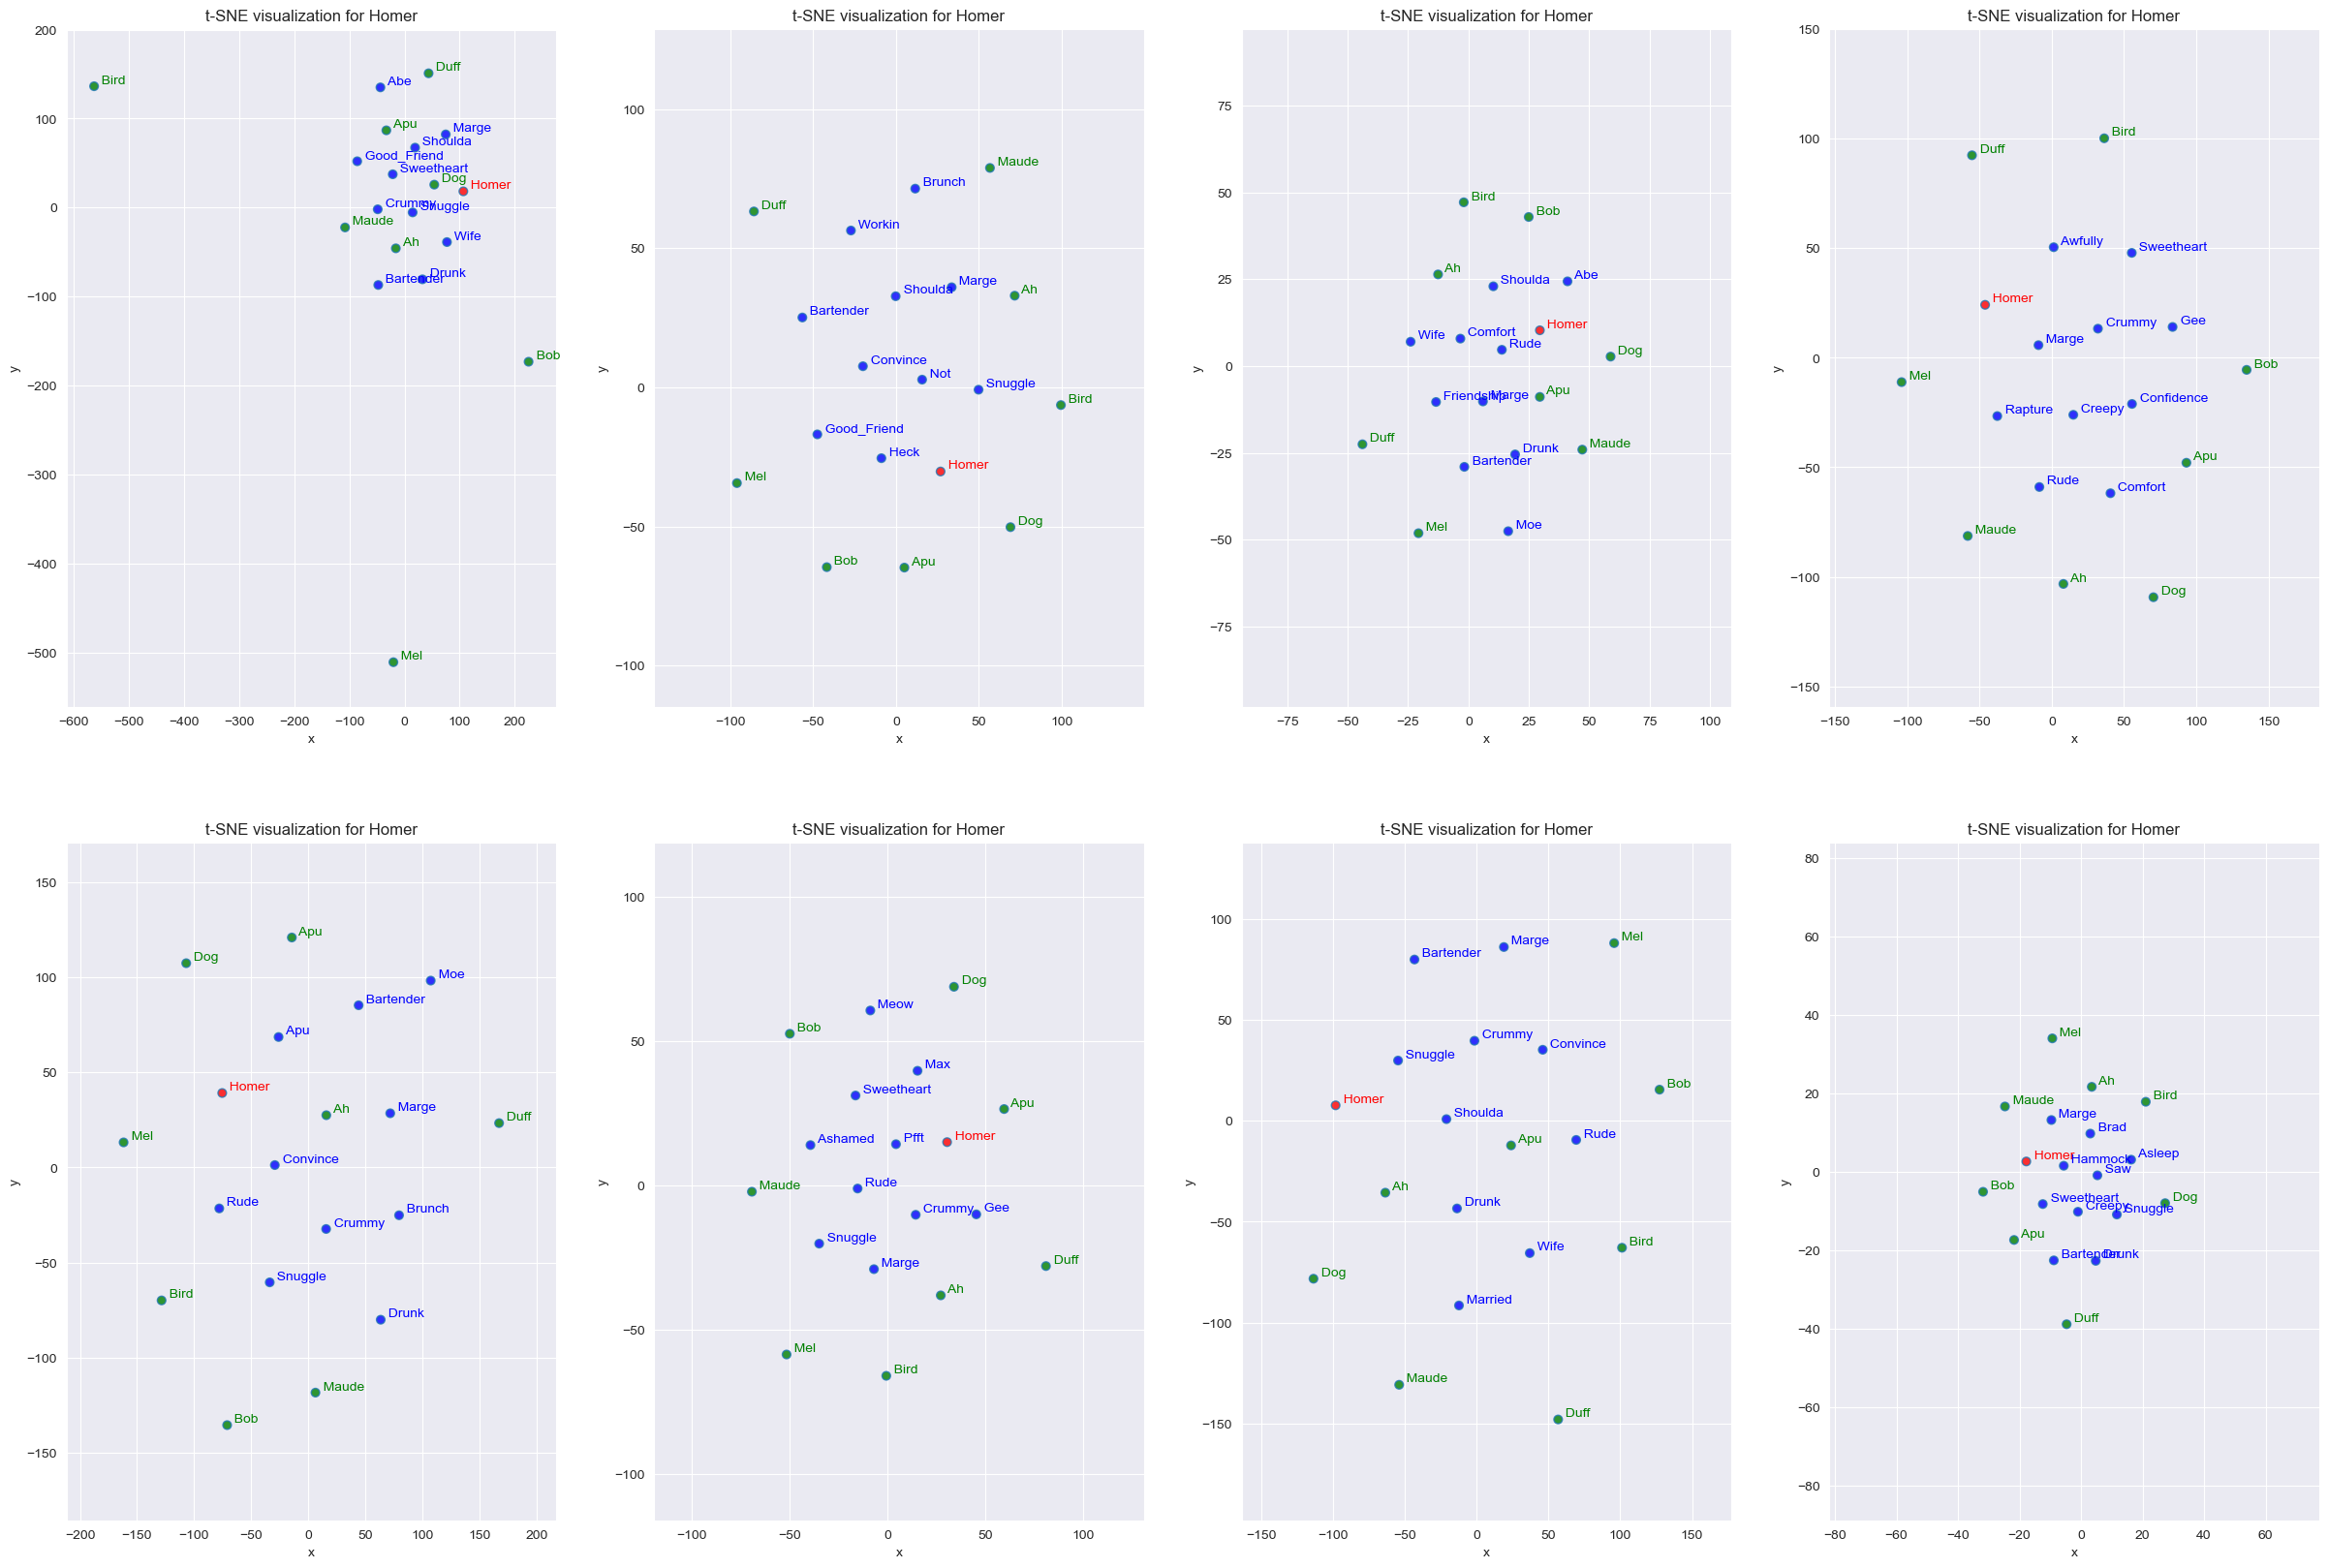

In [196]:
model_names = ['w2v_model1', 'w2v_model2', 'w2v_model3', 'w2v_model4', 
               'w2v_model5', 'w2v_model6', 'w2v_model7', 'w2v_model8']
additional_words = ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff']
fig, axes = plt.subplots(2, 4, figsize=(30, 20))  

axes = axes.flatten()

for i, model_name in enumerate(model_names):
    model = models[model_name] 
    tsnescatterplot(model, 'homer', additional_words, axes[i]) 

plt.show()


